In [122]:
import pandas as pd
import numpy as np
import os
import time
import random
import collections
import pickle
import re
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.cuda.amp import autocast, GradScaler
from datasets import Dataset
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from transformers import *
import matplotlib.pyplot as plt

In [2]:
CFG = {
    'fold_num': 5,
    'seed': 42,
    'model': 'squad2/infoxlm-squad2-512',
    'max_length': 512, 
    'doc_stride': 128,
    'epochs': 5, 
    'train_bs': 5, 
    'valid_bs': 8,
    'lr': 5e-6, 
    'weight_decay': 1e-6
}

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(CFG['seed'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [ ]:
def convert_answers(r):
    start = r[0]
    text = r[1]
    return {
        'answer_start': [start],
        'text': [text]
    }


train['answers'] = train[['answer_start', 'answer_text']].apply(convert_answers, axis=1)

train

In [6]:
def prepare_train_features(examples):
    # Some of the questions have lots of whitespace on the left, which is not useful and will make the
    # truncation of the context fail (the tokenized question will take a lots of space). So we remove that
    # left whitespace
    examples["question"] = [q.lstrip() for q in examples["question"]]

    # Tokenize our examples with truncation and padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question"],
        examples["context"],
        truncation="only_second",
        max_length=CFG['max_length'],
        stride=CFG['doc_stride'],
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

#     print(tokenized_examples)
    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    # The offset mappings will give us a map from token to character position in the original context. This will
    # help us compute the start_positions and end_positions.
    offset_mapping = tokenized_examples.pop("offset_mapping")

    # Let's label those examples!
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []
    tokenized_examples["has_answer"] = []
    
    for i, offsets in enumerate(offset_mapping):
        # We will label impossible answers with the index of the CLS token.
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]
        # If no answers are given, set the cls_index as answer.
        if len(answers["answer_start"]) == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            # Start/end character index of the answer in the text.
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])

            # Start token index of the current span in the text.
            token_start_index = 0
            while sequence_ids[token_start_index] != 1:
                token_start_index += 1

            # End token index of the current span in the text.
            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != 1:
                token_end_index -= 1

            # Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
                
                tokenized_examples["has_answer"].append(0)
            else:
                # Otherwise move the token_start_index and token_end_index to the two ends of the answer.
                # Note: we could go after the last offset if the answer is the last word (edge case).
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                tokenized_examples["start_positions"].append(token_start_index - 1)
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized_examples["end_positions"].append(token_end_index + 1)
                
                tokenized_examples["has_answer"].append(1)


    return tokenized_examples

In [7]:
def prepare_validation_features(examples):
    # Some of the questions have lots of whitespace on the left, which is not useful and will make the
    # truncation of the context fail (the tokenized question will take a lots of space). So we remove that
    # left whitespace
    examples["question"] = [q.lstrip() for q in examples["question"]]

    # Tokenize our examples with truncation and maybe padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question"],
        examples["context"],
        truncation="only_second",
        max_length=CFG['max_length'],
        stride=CFG['doc_stride'],
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    # We keep the example_id that gave us this feature and we will store the offset mappings.
    tokenized_examples["example_id"] = []

    for i in range(len(tokenized_examples["input_ids"])):
        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)
        context_index = 1

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        tokenized_examples["example_id"].append(examples["id"][sample_index])

        # Set to None the offset_mapping that are not part of the context so it's easy to determine if a token
        # position is part of the context or not.
        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == context_index else None)
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])
        ]

    return tokenized_examples

In [64]:
def postprocess_qa_predictions(examples, features, raw_predictions, predictions):
    all_start_logits, all_end_logits, all_start_positions, all_end_positions = raw_predictions
    
    example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
    features_per_example = collections.defaultdict(list)
    for i, feature in enumerate(features):
        features_per_example[example_id_to_index[feature["example_id"]]].append(i)

    for example_index, example in enumerate(tqdm(examples)):
        feature_indices = features_per_example[example_index]
        
        context = example["context"]
        offsets_start = {}
        offsets_end = {}
        y_start = {}
        y_end = {}

        for i, feature_index in enumerate(feature_indices):
            start_logits = all_start_logits[feature_index]
            end_logits = all_end_logits[feature_index]
            start_positions = all_start_positions[feature_index]
            end_positions = all_end_positions[feature_index]

            offset_mapping = features[feature_index]["offset_mapping"]
            
            for index in range(len(offset_mapping)):
                if offset_mapping[index] is None:
                    continue
                start_char = offset_mapping[index][0]
                end_char = offset_mapping[index][1]
                
                if start_char not in offsets_start.keys():
                    offsets_start[start_char] = start_logits[index]
                    offsets_end[start_char] = end_logits[index]
                else:
                    offsets_start[start_char] = max(start_logits[index], offsets_start[start_char])
                    offsets_end[start_char] = max(end_logits[index], offsets_end[start_char])
                y_start[start_char] = start_positions[index]
                y_end[start_char] = end_positions[index]
        
        start_logit = list(map(lambda x:x[1],sorted(list(offsets_start.items()), key=lambda x:x[0])))
        end_logit = list(map(lambda x:x[1],sorted(list(offsets_end.items()), key=lambda x:x[0])))
        start_pos = list(map(lambda x:x[1],sorted(list(y_start.items()), key=lambda x:x[0])))
        end_pos = list(map(lambda x:x[1],sorted(list(y_end.items()), key=lambda x:x[0])))

        predictions[example["id"]] = np.array(start_logit), np.array(end_logit), np.array(start_pos), np.array(end_pos)

In [66]:
seed_everything(CFG['seed'])

tokenizer = XLMRobertaTokenizerFast.from_pretrained(CFG['model'])

folds = StratifiedKFold(n_splits=CFG['fold_num'], shuffle=True, random_state=CFG['seed'])\
                    .split(np.arange(train.shape[0]), train['language'].values)

predictions = collections.OrderedDict()
    
for fold, (trn_idx, val_idx) in enumerate(folds):
    
    print(fold)
    
    df_valid = train.loc[val_idx].reset_index()
                
    valid_dataset = Dataset.from_pandas(df_valid)

    tokenized_valid_ds = valid_dataset.map(prepare_train_features, batched=True, remove_columns=valid_dataset.column_names)
    validation_features = valid_dataset.map(prepare_validation_features, batched=True, remove_columns=valid_dataset.column_names)
    
    valid_loader = DataLoader(tokenized_valid_ds, shuffle=False, collate_fn=default_data_collator, batch_size=CFG['valid_bs'])

    model = AutoModelForQuestionAnswering.from_pretrained(CFG['model']).to(device)
    model.load_state_dict(torch.load(f'output_fold{fold}.pt'))
    model.eval()
    
    all_start_logits, all_end_logits = [], []
    all_start_positions, all_end_positions = [], []
    
    with torch.no_grad():
        tk = tqdm(valid_loader, total=len(valid_loader), position=0, leave=True)
        for step, batch in enumerate(tk):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_positions = batch['start_positions']
            end_positions = batch['end_positions']
            start_positions = F.one_hot(start_positions, num_classes=512)
            end_positions = F.one_hot(end_positions, num_classes=512)
            
            output = model(input_ids, attention_mask)
            start_logits, end_logits = output['start_logits'], output['end_logits']
            
            all_start_logits.extend(start_logits.cpu().numpy())
            all_end_logits.extend(end_logits.cpu().numpy())
            all_start_positions.extend(start_positions.numpy())
            all_end_positions.extend(end_positions.numpy())

    all_start_logits, all_end_logits = np.array(all_start_logits), np.array(all_end_logits)
    all_start_positions, all_end_positions = np.array(all_start_positions), np.array(all_end_positions)
    
    postprocess_qa_predictions(valid_dataset, validation_features, \
                               (all_start_logits, all_end_logits, all_start_positions, all_end_positions), predictions)

0


100%|██████████| 223/223 [00:04<00:00, 51.22it/s]


1


100%|██████████| 223/223 [00:04<00:00, 50.15it/s]

2


100%|██████████| 223/223 [00:04<00:00, 52.15it/s]

3


100%|██████████| 223/223 [00:04<00:00, 45.57it/s]


4


100%|██████████| 222/222 [00:04<00:00, 51.85it/s]


In [ ]:
predictions

In [68]:
predictions['903deec17']

(array([ -0.60974824,  -1.626595  ,  -2.8772175 , ..., -10.411838  ,
        -11.255172  ,  -9.725088  ], dtype=float32),
 array([ -6.628245 ,  -4.6166973,  -7.699596 , ..., -11.531372 ,
         -8.989518 ,  -6.616979 ], dtype=float32),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int64))

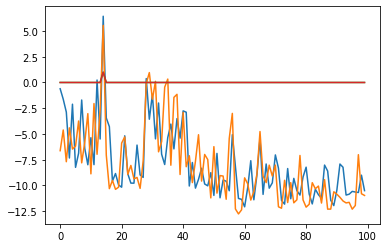

In [71]:
plt.plot(predictions['903deec17'][0][:100])
plt.plot(predictions['903deec17'][1][:100])
plt.plot(predictions['903deec17'][2][:100])
plt.plot(predictions['903deec17'][3][:100])
plt.show()

In [73]:
with open('predictions.pkl', 'wb')as f:
    pickle.dump(predictions, f)

In [74]:
train_new = train.copy()
train_new['oof'] = train_new['id'].apply(lambda r: predictions[r])
train_new

,id,context,question,answer_text,answer_start,language,answers,oof
0,903deec17,ஒரு சாதாரண வளர்ந்த மனிதனுடைய எலும்புக்கூடு பின...,மனித உடலில் எத்தனை எலும்புகள் உள்ளன?,206,53,tamil,"{'answer_start': [53], 'text': ['206']}","([-0.60974824, -1.626595, -2.8772175, -7.33781..."
1,d9841668c,காளிதாசன் (தேவநாகரி: कालिदास) சமஸ்கிருத இலக்கி...,காளிதாசன் எங்கு பிறந்தார்?,காசுமீரில்,2358,tamil,"{'answer_start': [2358], 'text': ['காசுமீரில்']}","([-0.8853339, -6.2211733, -7.3818793, -7.57116..."
2,29d154b56,சர் அலெக்ஸாண்டர் ஃபிளெமிங் (Sir Alexander Flem...,பென்சிலின் கண்டுபிடித்தவர் யார்?,சர் அலெக்ஸாண்டர் ஃபிளெமிங்,0,tamil,"{'answer_start': [0], 'text': ['சர் அலெக்ஸாண்ட...","([6.0533752, 3.0253131, -1.7136229, -4.234352,..."
3,41660850a,"குழந்தையின் அழுகையை நிறுத்தவும், தூங்க வைக்கவ...",தமிழ்நாட்டில் குழந்தைகளை தூங்க வைக்க பாடும் பா...,தாலாட்டு,68,tamil,"{'answer_start': [68], 'text': ['தாலாட்டு']}","([-4.8179026, -9.619563, -5.646538, -9.075521,..."
4,b29c82c22,சூரியக் குடும்பம் \nசூரியக் குடும்பம் (Solar S...,பூமியின் அருகில் உள்ள விண்மீன் எது?,சூரியனும்,585,tamil,"{'answer_start': [585], 'text': ['சூரியனும்']}","([2.733538, -7.6262894, -7.3691907, -6.8189816..."
...,...,...,...,...,...,...,...,...
1109,26f356026,स्वामी निगमानन्द परमहंस (18 अगस्त 1880 - 29 नव...,स्वामी निगमानन्द परमहंस के तन्त्र गुरु कौन थे?,बामाक्षेपा,2691,hindi,"{'answer_start': [2691], 'text': ['बामाक्षेपा']}","([-4.185486, -7.1889625, -9.548689, -8.3702345..."
1110,31179f1bb,भरत मुनि ने नाट्यशास्त्र नामक प्रसिद्ध ग्रन्थ ...,नित्यशास्त्र किसने लिखा है?,भरत मुनि,0,hindi,"{'answer_start': [0], 'text': ['भरत मुनि']}","([2.2612333, -6.0810027, -2.673243, -5.9799223..."
1111,0d35dc007,अग्नि पंचम (अग्नि-५) भारत की अन्तरमहाद्वीपीय ब...,अग्नि पंचम(५) मिसाइल की लम्बाई कितने मीटर है?,17,155,hindi,"{'answer_start': [155], 'text': ['17']}","([1.1368611, -1.6244228, -5.0437484, -3.076659..."
1112,7f997884d,"जलाल उद्दीन मोहम्मद अकबर () (१५ अक्तूबर, १५४२-...",मुगल सम्राट अकबर की मृत्यु किस वर्ष में हुई थी?,"२७ अक्तूबर, १६०५",46,hindi,"{'answer_start': [46], 'text': ['२७ अक्तूबर, १...","([-5.1720266, -9.692674, -7.3828955, -10.42519..."


In [100]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        x1, x2, y1, y2 = self.df.oof.values[idx]
        return np.concatenate([[x1], [x2]], 0).transpose(), y1.argmax(), y2.argmax()

In [101]:
MyDataset(train_new)[0]

(array([[ -0.60974824,  -6.628245  ],
        [ -1.626595  ,  -4.6166973 ],
        [ -2.8772175 ,  -7.699596  ],
        ...,
        [-10.411838  , -11.531372  ],
        [-11.255172  ,  -8.989518  ],
        [ -9.725088  ,  -6.616979  ]], dtype=float32),
 14,
 14)

In [109]:
torch.ones((32,512,2)).split(1, dim=-1)[0].squeeze(-1).shape

torch.Size([32, 512])

In [118]:
def collate_fn(data):
    data_length = torch.tensor([len(x[0]) for x in data])
    text = [torch.tensor(x[0]) for x in data]
    label1 = torch.tensor([x[1] for x in data])
    label2 = torch.tensor([x[2] for x in data])
    text = pad_sequence(text, batch_first=True, padding_value=0)
    return text, data_length, label1, label2

In [128]:
class RNNModel(nn.Module):
    def __init__(self, input_dim=2, lstm_dim=128, num_classes=2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, lstm_dim, batch_first=True, bidirectional=True, num_layers=2)
        self.fc = nn.Linear(lstm_dim*2, num_classes)

    def forward(self, x, lens):
        x = pack_padded_sequence(x, lens.cpu().numpy(), batch_first=True, enforce_sorted=False)
        x, _ = self.lstm(x)
        x, lens = pad_packed_sequence(x, batch_first=True)
        y = self.fc(x)
        y1, y2 = y.split(1, dim=-1)
        return y1.squeeze(-1), y2.squeeze(-1)

In [125]:
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
        
def train_model(model, train_loader):
    model.train() 
    
    losses = AverageMeter()
    
    optimizer.zero_grad()
    
    tk = tqdm(train_loader, total=len(train_loader), position=0, leave=True)
    for step, batch in enumerate(tk):
        x, l, y1, y2 = [b.to(device) for b in batch]
        
        with autocast():
            output1, output2 = model(x, l)
            loss = (criterion(output1, y1) + criterion(output2, y2))/2

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad() 
            
        lr = optimizer.param_groups[-1]['lr']

        losses.update(loss.item(), x.size(0))
        tk.set_postfix(loss=losses.avg, lr=lr)
  
    return losses.avg


def test_model(model, val_loader):
    model.eval()
    
    losses = AverageMeter()
    accs = AverageMeter()
    
    with torch.no_grad():
        tk = tqdm(val_loader, total=len(val_loader), position=0, leave=True)
        for step, batch in enumerate(tk):
            x, l, y1, y2 = [b.to(device) for b in batch]

            output1, output2 = model(x, l)
            loss = (criterion(output1, y1) + criterion(output2, y2))/2
            acc = (output1.argmax(1)==y1).sum()/len(y1) + (output2.argmax(1)==y2).sum()/len(y2)
            losses.update(loss.item(), x.size(0))
            accs.update(acc.item()/2, x.size(0))
            tk.set_postfix(loss=losses.avg, acc=accs.avg)
       
    return losses.avg, accs.avg

In [ ]:
seed_everything(CFG['seed'])

folds = KFold(n_splits=CFG['fold_num'], shuffle=True, random_state=CFG['seed']).split(np.arange(train_new.shape[0]))

cv = [] 

for fold, (trn_idx, val_idx) in enumerate(folds):

    if fold > 0:
        break
        
    train = train_new.loc[trn_idx].reset_index(drop=True)
    val = train_new.loc[val_idx].reset_index(drop=True)

    train_set = MyDataset(train)
    val_set = MyDataset(val)

    train_loader = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_set, batch_size=32, shuffle=False, collate_fn=collate_fn)

    best_score = 0

    model = RNNModel().to(device)
    
    scaler = GradScaler()
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(50):

        print('epoch:',epoch)
        time.sleep(0.2)

        train_loss = train_model(model, train_loader)
        val_loss, val_score = test_model(model, val_loader)

        if val_score > best_score:
            best_score = val_score
            torch.save(model.state_dict(), '{}_fold{}.pt'.format('RNN', fold))

    print(best_score) 
    cv.append(best_score)

epoch: 0


100%|██████████| 7/7 [00:04<00:00,  1.62it/s, acc=0.341, loss=6.84]


epoch: 1


100%|██████████| 7/7 [00:04<00:00,  1.58it/s, acc=0.33, loss=3.69] 


epoch: 2


100%|██████████| 7/7 [00:04<00:00,  1.58it/s, acc=0.482, loss=2.8] 


epoch: 3


100%|██████████| 7/7 [00:04<00:00,  1.55it/s, acc=0.52, loss=2.33] 


epoch: 4


100%|██████████| 7/7 [00:04<00:00,  1.56it/s, acc=0.592, loss=2.01]


epoch: 5


100%|██████████| 7/7 [00:04<00:00,  1.51it/s, acc=0.621, loss=1.82]


epoch: 6


100%|██████████| 7/7 [00:04<00:00,  1.56it/s, acc=0.626, loss=1.71]


epoch: 7


100%|██████████| 7/7 [00:04<00:00,  1.59it/s, acc=0.639, loss=1.65]


epoch: 8


100%|██████████| 7/7 [00:04<00:00,  1.51it/s, acc=0.639, loss=1.63]


epoch: 9


100%|██████████| 7/7 [00:04<00:00,  1.58it/s, acc=0.641, loss=1.61]


epoch: 10


100%|██████████| 7/7 [00:04<00:00,  1.57it/s, acc=0.641, loss=1.59]


epoch: 11


100%|██████████| 7/7 [00:04<00:00,  1.59it/s, acc=0.655, loss=1.59]


epoch: 12


100%|██████████| 7/7 [00:04<00:00,  1.55it/s, acc=0.655, loss=1.57]


epoch: 13


100%|██████████| 7/7 [00:04<00:00,  1.60it/s, acc=0.661, loss=1.56]


epoch: 14


100%|██████████| 7/7 [00:04<00:00,  1.59it/s, acc=0.659, loss=1.57]


epoch: 15


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 16


100%|██████████| 7/7 [00:04<00:00,  1.61it/s, acc=0.661, loss=1.55]


epoch: 17


100%|██████████| 7/7 [00:04<00:00,  1.55it/s, acc=0.668, loss=1.55]


epoch: 18


100%|██████████| 7/7 [00:04<00:00,  1.57it/s, acc=0.655, loss=1.55]


epoch: 19


100%|██████████| 7/7 [00:04<00:00,  1.57it/s, acc=0.657, loss=1.55]


epoch: 20


100%|██████████| 7/7 [00:04<00:00,  1.56it/s, acc=0.659, loss=1.54]


epoch: 21


100%|██████████| 7/7 [00:04<00:00,  1.55it/s, acc=0.657, loss=1.55]


epoch: 22


100%|██████████| 7/7 [00:04<00:00,  1.57it/s, acc=0.661, loss=1.55]


epoch: 23


100%|██████████| 7/7 [00:04<00:00,  1.57it/s, acc=0.668, loss=1.54]


epoch: 24


100%|██████████| 7/7 [00:04<00:00,  1.61it/s, acc=0.657, loss=1.54]


epoch: 25


100%|██████████| 7/7 [00:04<00:00,  1.63it/s, acc=0.661, loss=1.55]


epoch: 26


100%|██████████| 7/7 [00:04<00:00,  1.58it/s, acc=0.661, loss=1.54]


epoch: 27


100%|██████████| 7/7 [00:04<00:00,  1.59it/s, acc=0.664, loss=1.53]


epoch: 28


100%|██████████| 7/7 [00:04<00:00,  1.58it/s, acc=0.666, loss=1.53]


epoch: 29


100%|██████████| 7/7 [00:04<00:00,  1.55it/s, acc=0.652, loss=1.54]


epoch: 30


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 31


100%|██████████| 7/7 [00:04<00:00,  1.48it/s, acc=0.664, loss=1.53]


epoch: 32


100%|██████████| 7/7 [00:04<00:00,  1.62it/s, acc=0.67, loss=1.53] 


epoch: 33


 75%|███████▌  | 21/28 [00:20<00:07,  1.03s/it, loss=1.32, lr=0.0003]